In [1]:
import os, sys
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if root not in sys.path:
    sys.path.insert(0, root)

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from itertools import product
from tqdm import tqdm
from copy import deepcopy
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import ScalarMappable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import warnings
from matplotlib import rcParams
import esm
from sklearn.manifold import TSNE

rcParams["font.family"] = "Lato"
rcParams["font.size"] = 16
rcParams['text.color'] = '#3F3F3F'
rcParams['axes.labelcolor'] = '#3F3F3F'
rcParams['xtick.color'] = '#3F3F3F'
rcParams['ytick.color'] = '#3F3F3F'
TEAL = ["#b5d1ae", "#80ae9a", "#568b87", "#326b77", "#1b485e", "#122740"]

FEATURES = ["length","is_assembled","ap","has_beta_sheet_content","hydrophobic_moment","net_charge"]
MAX_FASTA_LENGTH = 10
SPHERE_OK = 0.75
FIBER_OK  = 0.35

from classifier.models import PeptidePredictor
from cvae.models import CVAESimpleEnc
from cvae.utils import (
    CONDITION_LENGTH, MAX_SEQ_LENGTH, PAD_TOKEN_ID, ALPHABET, BOS_ID, EOS_ID,
    esm_model_pretrained, idx_to_fasta, convert_and_pad,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
peptide_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
print(peptide_device)
print(torch.cuda.device_count())

cuda
cuda
1


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device, torch.cuda.device_count())

cvae_model = CVAESimpleEnc(
    encoder_hidden_dim=256,
    num_encoder_layers=2,
    vocab_size=len(ALPHABET),
    latent_dim=24,
    cond_dim=CONDITION_LENGTH,
    max_seq_length=MAX_SEQ_LENGTH,
    decoder_hidden_dim=256,
    num_decoder_layers=2,
    nhead=8,
    dropout=0.1)

pretrained_state_dict = torch.load("../masked_cvae/chkpts/finetuned_cvae.pt", map_location=device, weights_only=True)
cvae_model.load_state_dict(pretrained_state_dict)

cuda 1


<All keys matched successfully>

In [ ]:
peptide_predictor = PeptidePredictor(deepcopy(esm_model_pretrained), alphabet=ALPHABET)

peptide_predictor_dict = torch.load("../ap_model/peptide_predictor.pt", map_location=device, weights_only=True)
peptide_predictor.load_state_dict(peptide_predictor_dict)

<All keys matched successfully>

In [5]:
cvae_model.eval()
peptide_predictor.eval()

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    cvae_model = nn.DataParallel(cvae_model)

cvae_model.to(device)
peptide_predictor.to(peptide_device)
print("CVAE and Peptide Predictor initialized")

CVAE and Peptide Predictor initialized


# Generation

In [6]:
def to_fasta(tokens):
    fasta = ''
    for token in tokens:
        if token == 2:
            break
        if token in [0, 1, 3, 29, 30, 31, 32]:
            continue
        else:
            fasta += idx_to_fasta[token]
    return fasta      

In [7]:
FEATURES = [
    "length",
    "is_assembled",
    "ap",
    "has_beta_sheet_content",
    "hydrophobic_moment",
    "net_charge",
]

MAX_FASTA_LENGTH = 10

def generate_cond_mask_vectors(device, **kwargs):
    condition = torch.zeros(len(FEATURES), dtype=torch.float, device=device)
    mask = torch.zeros(len(FEATURES), dtype=torch.float, device=device)

    for idx, feature in enumerate(FEATURES):
        value = kwargs.get(feature, None)
        if value is not None:
            condition[idx] = value if feature != 'length' else value / MAX_FASTA_LENGTH
            mask[idx] = 1.0
    return condition, mask


In [8]:
def sample_from_prior_ar(
    model, condition, mask,
    temperature=1.0,
    n=1,
):
    """
    1) z ~ p(z|c) instead of N(0,I)
    2) Autoregressively decode, starting from BOS, stopping on EOS or max `max_length`
    """
    m = model.module if hasattr(model, "module") else model
    m.eval()

    # batch‑ify condition & mask
    if n == 1:
        condition = condition.unsqueeze(0)
        mask      = mask.unsqueeze(0)
    else:
        condition = condition.repeat(n, 1)
        mask      = mask.repeat(n, 1)

    device = next(m.parameters()).device
    condition, mask = condition.to(device), mask.to(device)
    B = condition.size(0)
    summary = m.compute_summary(condition, mask)
    prior_mu, prior_logvar = m.compute_prior(summary)
    z = m.reparameterize(prior_mu, prior_logvar)
    # sample from normal distribution
    # z = torch.randn(B, m.latent_dim, device=device)
    # cond_pred_from_prior = m.prior_cond_decoder(z)
    #cond_summary = m.compute_cond_summary(condition, mask)

    seq = torch.full((B, 1), BOS_ID,
                     dtype=torch.long, device=device)

    finished = torch.zeros(B, dtype=torch.bool, device=device)
    outputs  = torch.full((B, MAX_SEQ_LENGTH), PAD_TOKEN_ID,
                          dtype=torch.long, device=device)

    for t in range(MAX_SEQ_LENGTH):
        logits = m.decode(z, seq, summary)

        next_logits = logits[:, -1, :]
        if temperature == 1.0:
            next_token = next_logits.argmax(dim=-1, keepdim=True)
        else:
            probs = torch.nn.functional.softmax(next_logits / temperature, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

        outputs[:, t] = next_token.squeeze(1)

        seq = torch.cat([seq, next_token], dim=1)

        finished = finished | (next_token.squeeze(1) == EOS_ID)
        if finished.all():
            break

    outs = []
    for i, row in enumerate(outputs.tolist()):
        if EOS_ID in row:
            cut = row.index(EOS_ID)
            toks = row[:cut]
        else:
            toks = row
        fasta = to_fasta(toks)
        outs.append((fasta, len(fasta)))#, cond_pred_from_prior[i, :].cpu().tolist()))

    return outs


In [9]:
condition, mask = generate_cond_mask_vectors(device=device,
                                             length=9,
                                            is_assembled=0,
                                            ap=0.02,
                                            beta_sheet_fraction=0,
                                            extension_ratio=0.47,
                                            hydrophobic_moment=0.12,
                                            planarity_index=0.64,
                                            curvature_score=0.886,
                                            radius_of_gyration=0.069,
                                            alternating_pattern_score=0.09,
                                            net_charge=0.66,
                                            aromatic_interaction_score=0)
condition, mask

(tensor([0.9000, 0.0000, 0.0200, 0.0000, 0.1200, 0.6600], device='cuda:0'),
 tensor([1., 1., 1., 0., 1., 1.], device='cuda:0'))

In [10]:
condition, mask = generate_cond_mask_vectors(device=device, 
                                            length=6,
                                            #ap=0.7,
                                            is_assembled=1,
                                            has_beta_sheet_content=1,
                                            #hydrophobic_moment=0.7
                                             )
condition, mask

(tensor([0.6000, 1.0000, 0.0000, 1.0000, 0.0000, 0.0000], device='cuda:0'),
 tensor([1., 1., 0., 1., 0., 0.], device='cuda:0'))

In [11]:
samples = sample_from_prior_ar(
    cvae_model, condition, mask,
    temperature=1.0,
    n=1000
)

In [12]:
samples

[('EWPGFT', 6),
 ('ECYFGT', 6),
 ('DAKCWYT', 7),
 ('AYFPDG', 6),
 ('APNIVS', 6),
 ('VYTCFD', 6),
 ('RFHTDE', 6),
 ('SIHFYFK', 7),
 ('IEFSYG', 6),
 ('EIWINH', 6),
 ('LWRGEG', 6),
 ('GRVLGV', 6),
 ('ILATIM', 6),
 ('RTPGFI', 6),
 ('GETIFY', 6),
 ('IPSGWP', 6),
 ('LAQGGIF', 7),
 ('PAFYVY', 6),
 ('KYGAVH', 6),
 ('RFGMDV', 6),
 ('IITPGFC', 7),
 ('YCGQC', 5),
 ('YCPGMW', 6),
 ('IIPGLV', 6),
 ('IVDCQW', 6),
 ('PVEWRD', 6),
 ('HYNVQF', 6),
 ('PIVGTSF', 7),
 ('VFEYMW', 6),
 ('VLTSFQ', 6),
 ('YVYDIT', 6),
 ('QAGHPL', 6),
 ('PVFDVP', 6),
 ('RWRYDV', 6),
 ('IRWVPC', 6),
 ('VNVVNV', 6),
 ('LYISLW', 6),
 ('CGCCGC', 6),
 ('RMWSVFA', 7),
 ('FCFLIC', 6),
 ('ILFHCM', 6),
 ('FAQFLPL', 7),
 ('CVTDWM', 6),
 ('TWEPAF', 6),
 ('GHCKIY', 6),
 ('GVYGVY', 6),
 ('KIRECW', 6),
 ('QHESTW', 6),
 ('VSFHKE', 6),
 ('GFKGTW', 6),
 ('QWPGHPV', 7),
 ('FLNGEFT', 7),
 ('TIQSTFK', 7),
 ('CFLAQA', 6),
 ('EWPIQC', 6),
 ('VMESFH', 6),
 ('FHDTAP', 6),
 ('PILGQC', 6),
 ('HITLEC', 6),
 ('EVNFHG', 6),
 ('VPCFHPI', 7),
 ('FASQWS', 6)

In [13]:
def generate_samples_from_conditions(cvae_model, device, feature_ranges, temperature=1.0, n=1000):
    """
    Generate and return a list of samples for each combination of conditions specified in feature_ranges.
    
    Parameters:
    - cvae_model: your trained conditional VAE model
    - device: torch device (e.g., 'cpu' or 'cuda')
    - feature_ranges: dict mapping feature names (matching generate_cond_mask_vectors args)
                      to lists of normalized values (0-1)
    - temperature: sampling temperature
    - n: number of samples per condition

    Returns:
    - results: list of dicts, each with keys:
        'params': dict of feature values,
        'samples': tensor of generated sequences for that condition
    """
    results = []
    pbar = tqdm(product(*feature_ranges.values()), desc="Generating samples", total=len(list(product(*feature_ranges.values()))))
    for combo in pbar:
        params = dict(zip(feature_ranges.keys(), combo))
        condition, mask = generate_cond_mask_vectors(device=device, **params)
        samples = sample_from_prior_ar(cvae_model, condition, mask, temperature=temperature, n=n)
        results.extend(samples)
    return results

# Morphology Based Generation

In [14]:
amino_acid_dict = {
    'A': 'Ala', 'C': 'Cys', 'D': 'Asp', 'E': 'Glu', 'F': 'Phe', 'G': 'Gly',
    'H': 'His', 'I': 'Ile', 'K': 'Lys', 'L': 'Leu', 'M': 'Met', 'N': 'Asn',
    'P': 'Pro', 'Q': 'Gln', 'R': 'Arg', 'S': 'Ser', 'T': 'Thr', 'V': 'Val',
    'W': 'Trp', 'Y': 'Tyr'
}

def convert_to_three_letter(seq):
    return '-'.join([amino_acid_dict[aa] for aa in seq])

In [15]:
def classify_and_append(model, batch_data, device="cuda", batch_size=2056, ap_cutoff=0.43, clas_cutoff=0.75):
    """
    Processes input data in batches and shows progress via tqdm.

    Args:
        model: classifier that takes tokens as input and returns (ap_pred, cls_pred)
        batch_data: list of tuples (sequence, length, array_of_preds)
        device: 'cuda' or 'cpu'
        batch_size: number of samples per batch

    Returns:
        List of tuples (sequence, length, array_of_preds, ap_prediction, cls_prediction)
    """
    results = []
    model.to(device)
    model.eval()

    for start_idx in tqdm(range(0, len(batch_data), batch_size), desc="Classifying batches"):
        chunk = batch_data[start_idx:start_idx + batch_size]
        data = [(f"peptide_{start_idx + i}", seq) for i, (seq, _,) in enumerate(chunk)]
        tokens = convert_and_pad(data, seq_length=MAX_SEQ_LENGTH).to(device)

        with torch.no_grad():
            ap_preds, cls_preds = model(tokens)

        for (seq, length), ap_pred, cls_pred in zip(chunk, ap_preds, cls_preds):
            ap_val = ap_pred.item()
            cls_val = cls_pred.item()
            if ap_val < ap_cutoff or cls_val < clas_cutoff:
                continue
            results.append((seq, convert_to_three_letter(seq), length, ap_val, cls_val))

    return results

## Fibers/Tubes Generation

In [17]:
fiber_ranges = {
    'length': (7, 11, 1),
    'is_assembled': (1, 2, 1),
    'has_beta_sheet_content': (1, 2, 1),
    #'hydrophobic_moment': (0.5, 0.7, 0.05),
    'net_charge': (0.4, 0.6, 0.05),
}

fiber_ranges_values = {
    key: np.arange(v[0], v[1], v[2]).tolist()
    for key, v in fiber_ranges.items()
}

fiber_ranges_values

{'length': [7, 8, 9, 10],
 'is_assembled': [1],
 'has_beta_sheet_content': [1],
 'net_charge': [0.4, 0.45, 0.5, 0.55]}

In [18]:
4*4*300

4800

In [19]:
fiber_samples = generate_samples_from_conditions(
    cvae_model=cvae_model,
    device=device,
    feature_ranges=fiber_ranges_values,
    n=300
)

Generating samples: 100%|██████████| 16/16 [00:01<00:00, 12.70it/s]


In [75]:
fiber_samples

[('WEPGTPW', 7),
 ('AKTPEMWH', 8),
 ('KIETGFE', 7),
 ('ELHYTPYN', 8),
 ('FYCAEFT', 7),
 ('CHITDWV', 7),
 ('VFIYCFV', 7),
 ('PYFEYAI', 7),
 ('AYHYGPD', 7),
 ('FDANWHL', 7),
 ('IRFAGEV', 7),
 ('VLGPGCC', 7),
 ('ILPPGWFE', 8),
 ('PEFPDYH', 7),
 ('DHVEFFIC', 8),
 ('YDPQAIFW', 8),
 ('VVVNDWMW', 8),
 ('VNGCTDFW', 8),
 ('KDYHYLV', 7),
 ('HIEPGWSF', 8),
 ('EKFYDKW', 7),
 ('FLAHNDPF', 8),
 ('WAVDPTS', 7),
 ('IQYFCFV', 7),
 ('QFSECIV', 7),
 ('CFEGEND', 7),
 ('QLFPGFDG', 8),
 ('DIVVESL', 7),
 ('VVGTIPV', 7),
 ('QWDCQITY', 8),
 ('FLFENPL', 7),
 ('LCDVLGPC', 8),
 ('VFVSVMV', 7),
 ('WYGTFDW', 7),
 ('FLDTAIEF', 8),
 ('YTKDDYYG', 8),
 ('CFTGMEC', 7),
 ('AIPDQYC', 7),
 ('VHGPVWH', 7),
 ('IAIEWPW', 7),
 ('MFLFDVV', 7),
 ('LYPCTDC', 7),
 ('EFLPFDL', 7),
 ('LQIEVYS', 7),
 ('VRLPDCS', 7),
 ('IPLDMAIP', 8),
 ('TYPIYAV', 7),
 ('IGWIDSA', 7),
 ('HAISTGV', 7),
 ('IRYGVDE', 7),
 ('YLQGEYMF', 8),
 ('VAPTDFY', 7),
 ('FVFIDCP', 7),
 ('YWQIFPA', 7),
 ('QYCPFWDW', 8),
 ('FIKPDTI', 7),
 ('WANDWSC', 7),
 ('VLWVDYC', 7

In [76]:
# save generated fibers to file
with open("generated_fibers_init.txt", "w") as f:
    for seq, length in fiber_samples:
        f.write(f"{seq}\n")

In [77]:
len(fiber_samples), len(set(fiber_samples))

(4800, 4800)

In [78]:
fiber_valid_samples = classify_and_append(peptide_predictor, list(set(fiber_samples)), device=peptide_device)
len(fiber_valid_samples)

Classifying batches:   0%|          | 0/3 [00:00<?, ?it/s]

Classifying batches: 100%|██████████| 3/3 [00:00<00:00,  3.61it/s]


3794

In [79]:
sorted([(seq, three_seq, ap, cls_) for seq, three_seq, _, ap, cls_ in fiber_valid_samples], key=lambda x: x[2], reverse=True)

[('FCVPFSW',
  'Phe-Cys-Val-Pro-Phe-Ser-Trp',
  0.6623907089233398,
  0.9999998807907104),
 ('FVPIFYG',
  'Phe-Val-Pro-Ile-Phe-Tyr-Gly',
  0.6554569005966187,
  0.9999996423721313),
 ('FIPFLWN',
  'Phe-Ile-Pro-Phe-Leu-Trp-Asn',
  0.6524701118469238,
  0.9999992847442627),
 ('FFQGIFP',
  'Phe-Phe-Gln-Gly-Ile-Phe-Pro',
  0.649649441242218,
  0.9999927282333374),
 ('FCFVGVVPPF',
  'Phe-Cys-Phe-Val-Gly-Val-Val-Pro-Pro-Phe',
  0.6483261585235596,
  0.9999995231628418),
 ('FYCFPFV',
  'Phe-Tyr-Cys-Phe-Pro-Phe-Val',
  0.6476225852966309,
  0.9999997615814209),
 ('FLPPFSIC',
  'Phe-Leu-Pro-Pro-Phe-Ser-Ile-Cys',
  0.6459331512451172,
  0.9999984502792358),
 ('FMFIGNF',
  'Phe-Met-Phe-Ile-Gly-Asn-Phe',
  0.6459167003631592,
  0.999992847442627),
 ('LFFPIFY',
  'Leu-Phe-Phe-Pro-Ile-Phe-Tyr',
  0.6408709287643433,
  0.9999997615814209),
 ('FYFLFIVP',
  'Phe-Tyr-Phe-Leu-Phe-Ile-Val-Pro',
  0.6402570009231567,
  0.9999995231628418),
 ('FLFPCYC',
  'Phe-Leu-Phe-Pro-Cys-Tyr-Cys',
  0.6387918591499329,

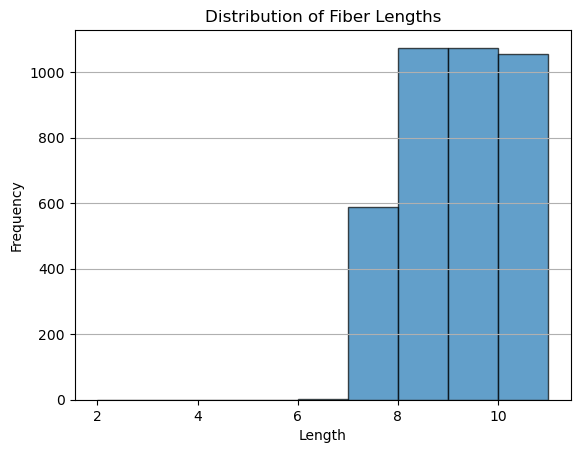

In [ ]:
# show distribution of lengths
lengths = [len(seq) for seq, _, _, ap, cls_ in fiber_valid_samples]
plt.hist(lengths, bins=range(2, 12), edgecolor='black', alpha=0.7)
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Distribution of Fiber Lengths')
plt.grid(axis='y')
plt.show()

## Spheres/Vesicles Sheets

In [20]:
spheres_ranges = {
    'length': (4, 8, 1),
    'is_assembled': (1, 2, 1),
    'hydrophobic_moment': (0.6, 1.05, 0.1),
    'net_charge': (0.4, 0.6, 0.05),
}

spheres_ranges_values = {
    key: np.arange(v[0], v[1], v[2]).tolist()
    for key, v in spheres_ranges.items()
}

In [33]:
spheres_ranges_values

{'length': [4, 5, 6, 7],
 'is_assembled': [1],
 'hydrophobic_moment': [0.6,
  0.7,
  0.7999999999999999,
  0.8999999999999999,
  0.9999999999999999],
 'net_charge': [0.4, 0.45, 0.5, 0.55]}

In [34]:
spheres_samples = generate_samples_from_conditions(
    cvae_model=cvae_model,
    device=device,
    feature_ranges=spheres_ranges_values,
    n=60
)

len(spheres_samples), len(set(spheres_samples))

Generating samples: 100%|██████████| 80/80 [00:01<00:00, 56.77it/s]


(4800, 4697)

In [35]:
with open("generated_spheres_init.txt", "w") as f:
    for seq, length in spheres_samples:
        f.write(f"{seq}\n")

In [36]:
spheres_valid_samples = classify_and_append(peptide_predictor, list(set(spheres_samples)), device=peptide_device)
len(spheres_valid_samples)

Classifying batches:   0%|          | 0/3 [00:00<?, ?it/s]

Classifying batches: 100%|██████████| 3/3 [00:00<00:00,  3.71it/s]


3986

In [37]:
sorted([(seq, three_seq, ap, cls_) for seq, three_seq, _, ap, cls_ in spheres_valid_samples], key=lambda x: x[2], reverse=True)

[('FVLF', 'Phe-Val-Leu-Phe', 0.7243413329124451, 0.9999997615814209),
 ('FVWL', 'Phe-Val-Trp-Leu', 0.7215538620948792, 0.9999998807907104),
 ('VLFF', 'Val-Leu-Phe-Phe', 0.7192361950874329, 0.9999997615814209),
 ('VFLF', 'Val-Phe-Leu-Phe', 0.7171876430511475, 0.9999995231628418),
 ('LVYF', 'Leu-Val-Tyr-Phe', 0.7148734331130981, 0.9999996423721313),
 ('WVLF', 'Trp-Val-Leu-Phe', 0.7143211960792542, 1.0),
 ('VLYF', 'Val-Leu-Tyr-Phe', 0.7115874290466309, 0.9999994039535522),
 ('LVFY', 'Leu-Val-Phe-Tyr', 0.7114782333374023, 0.9999997615814209),
 ('YVLF', 'Tyr-Val-Leu-Phe', 0.7110663056373596, 0.9999995231628418),
 ('FVPF', 'Phe-Val-Pro-Phe', 0.7081660628318787, 0.9999997615814209),
 ('LVVF', 'Leu-Val-Val-Phe', 0.7056424617767334, 0.9999974966049194),
 ('FVLV', 'Phe-Val-Leu-Val', 0.7049210667610168, 0.9999895095825195),
 ('FIPVF', 'Phe-Ile-Pro-Val-Phe', 0.704868733882904, 0.9999995231628418),
 ('VLIF', 'Val-Leu-Ile-Phe', 0.7039605975151062, 0.9999949932098389),
 ('VFLFS', 'Val-Phe-Leu-Phe-Ser

In [90]:
with open("filtered_ap_peptides_fiber.txt", "w") as f:
    for i, item in enumerate(fiber_valid_samples, start=1):
        seq, three_seq, _, ap, cls_ = item
        f.write(f"{seq}, {three_seq}, {ap}, {cls_}\n")

In [91]:
with open("filtered_ap_peptides_fiber.fst", "w") as f:
    for i, item in enumerate(fiber_valid_samples, start=1):
        seq = item[0]
        f.write(f">peptide_{i}\n{seq}\n")

In [38]:
with open("filtered_ap_peptides_spheres.txt", "w") as f:
    for i, item in enumerate(spheres_valid_samples, start=1):
        seq, three_seq, _, ap, cls_ = item
        f.write(f"{seq}, {three_seq}, {ap}, {cls_}\n")

In [39]:
with open("filtered_ap_peptides_spheres.fst", "w") as f:
    for i, item in enumerate(spheres_valid_samples, start=1):
        seq = item[0]
        f.write(f">peptide_{i}\n{seq}\n")

# Latent Viz

In [ ]:
def build_cond_mask_from_row(row, feature_order=FEATURES):
    cond = np.zeros(len(feature_order), dtype=np.float32)
    mask = np.zeros(len(feature_order), dtype=np.float32)
    for i, feat in enumerate(feature_order):
        if feat in row.index and pd.notna(row[feat]):
            val = float(row[feat])
            if feat == "length":
                cond[i] = val / MAX_FASTA_LENGTH
            else:
                cond[i] = val
            mask[i] = 1.0
    return cond, mask

def project_2d(X, method="umap", random_state=42, n_neighbors=30, min_dist=0.15, perplexity=30):
    if X is None or len(X) == 0:
        return None, "None"
    if method == "umap":
        try:
            reducer = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist,
                                metric="cosine", random_state=random_state)
            Y = reducer.fit_transform(X)
            return Y, "UMAP"
        except Exception as e:
            warnings.warn(f"UMAP unavailable ({e}); falling back to t-SNE.")
    Y = TSNE(n_components=2, perplexity=perplexity, learning_rate="auto",
             init="pca", metric="cosine", random_state=random_state).fit_transform(X)
    return Y, "t-SNE"

_, ESM_ALPHABET = esm.pretrained.esm2_t12_35M_UR50D()
batch_converter = ESM_ALPHABET.get_batch_converter()

def encode_with_cvae_encoder(seq_list, batch_size=256, device=None):
    m = cvae_model.module if hasattr(cvae_model, "module") else cvae_model
    m.eval()
    device = device or next(m.parameters()).device
    mus = []
    with torch.no_grad():
        for i in range(0, len(seq_list), batch_size):
            chunk = [(str(j), s) for j, s in enumerate(seq_list[i:i+batch_size])]
            _, _, toks = batch_converter(chunk)
            toks = toks[:, 1:-1]
            toks = toks.to(device)
            mu_enc, logv_enc = m.encode(toks)
            mus.append(mu_enc.detach().cpu().numpy())
    return np.vstack(mus)

def label_success(target, is_target, rmoi):
    tgt = (str(target).lower() if pd.notna(target) else None)
    if pd.isna(rmoi):
        if tgt == "sphere": return "target_sphere"
        if tgt == "fiber":  return "target_fiber"
        return "target_unknown"
    if tgt == "sphere":
        return "sphere_success" if is_target == 'yes' else "sphere_fail"
    if tgt == "fiber":
        return "fiber_success"  if is_target == 'yes'else "fiber_fail"
    return "target_unknown"


In [102]:
df = pd.read_csv('gen_peptides/rmoi_and_ap_by_run.csv')
df['group'] = 'all'   # single category for split violin
low_thr, high_thr = 0.35, 0.75
min_ap, max_ap = 0.959986, 2.89703

#drop unnamed columns
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df

# sort by rmoi
df = df.sort_values(by='RMOI')

# each peptide has three runs (three entries)
# group by peptide, take mean of rmoi and ap, and according to is_target take majority vote for is_target
agg = df.groupby('peptide').agg(
    mean_rmoi=('RMOI', 'mean'),
    mean_ap=('aggregation_propensity', 'mean'),
    is_target=('is_target', lambda x: x.mode()[0] if not x.mode().empty else False),
    morphology=('morphology', 'first')
).reset_index()

#rename peptide to sequence
agg = agg.rename(columns={'peptide': 'sequence'})
agg

,sequence,mean_rmoi,mean_ap,is_target,morphology
0,CVSAPGIFHC,0.376627,1.959019,yes,fibers
1,FFIFI,0.841170,2.835215,yes,spheres
2,FFLFI,0.798208,2.727447,yes,spheres
3,FIFIF,0.449687,2.411279,no,spheres
4,FIFVF,0.332476,2.355055,no,spheres
...,...,...,...,...,...
25,QIRTYDFLVF,0.687460,2.160115,yes,fibers
26,RAVYGDFVFL,0.376509,2.173862,yes,fibers
27,VFFIF,0.906594,2.902559,yes,spheres
28,VFLVPVDFKY,0.580725,2.789320,no,fibers


In [103]:
fibers = pd.read_csv("gen_peptides/fibers_with_conditions.csv")
spheres = pd.read_csv("gen_peptides/spheres_with_conditions.csv")

# normalize columns
for df in (fibers, spheres):
    if "peptide" in df.columns and "sequence" not in df.columns:
        df.rename(columns={"peptide":"sequence"}, inplace=True)
    # keep only known feature names + sequence + index if present
    for c in list(df.columns):
        if c not in (["sequence","index"] + FEATURES):
            # it's fine to keep other numeric columns, but we'll ignore them
            pass

fibers["target_morphology"] = "fiber"
spheres["target_morphology"] = "sphere"
sim_df = pd.concat([fibers, spheres], ignore_index=True)
sim_df["sequence"] = sim_df["sequence"].astype(str).str.upper()
sim_df

,sequence,index,length,is_assembled,has_beta_sheet_content,net_charge,target_morphology,hydrophobic_moment
0,WEPGTPW,0,7,1,1.0,0.40,fiber,NaN
1,AKTPEMWH,1,7,1,1.0,0.40,fiber,NaN
2,KIETGFE,2,7,1,1.0,0.40,fiber,NaN
3,ELHYTPYN,3,7,1,1.0,0.40,fiber,NaN
4,FYCAEFT,4,7,1,1.0,0.40,fiber,NaN
...,...,...,...,...,...,...,...,...
9595,WYFFCIM,4795,7,1,NaN,0.55,sphere,1.0
9596,RDMRIHD,4796,7,1,NaN,0.55,sphere,1.0
9597,RYANECT,4797,7,1,NaN,0.55,sphere,1.0
9598,WRPERVC,4798,7,1,NaN,0.55,sphere,1.0


In [104]:
# ---------- 2) Merge RMOI/AP summary to label success ----------
rmoi_df = pd.read_csv("gen_peptides/rmoi_and_ap_summary.csv")
seq_col = "sequence" if "sequence" in rmoi_df.columns else ("peptide" if "peptide" in rmoi_df.columns else None)
if seq_col is None:
    raise ValueError("rmoi_and_ap_summary.csv must have a 'sequence' or 'peptide' column.")
rmoi_df = rmoi_df.rename(columns={seq_col:"sequence"})
rmoi_col = "RMOI" if "RMOI" in rmoi_df.columns else ("rmoi" if "rmoi" in rmoi_df.columns else None)
if rmoi_col is None:
    raise ValueError("rmoi_and_ap_summary.csv must include 'RMOI' (or 'rmoi').")

rmoi_df[rmoi_col] = pd.to_numeric(rmoi_df[rmoi_col], errors="coerce")


sim_df = sim_df.merge(rmoi_df[["sequence", rmoi_col]], on="sequence", how="left")
sim_df = sim_df.assign(_has_rmoi = sim_df[rmoi_col].notna()) \
               .sort_values(["sequence","_has_rmoi"], ascending=[True, False]) \
               .drop_duplicates(subset="sequence", keep="first") \
               .drop(columns="_has_rmoi")

sim_df["target_morphology"] = sim_df["target_morphology"].astype(str)
sim_df


,sequence,index,length,is_assembled,has_beta_sheet_content,net_charge,target_morphology,hydrophobic_moment,RMOI
832,AAFQFAFW,832,7,1,1.0,0.50,fiber,NaN,NaN
9082,AAIGILP,4282,7,1,NaN,0.55,sphere,0.8,NaN
3084,AAKEWSYHW,3084,9,1,1.0,0.50,fiber,NaN,NaN
1970,AALQFWVY,1970,8,1,1.0,0.50,fiber,NaN,NaN
4092,AATPYHYIAW,4092,10,1,1.0,0.45,fiber,NaN,NaN
...,...,...,...,...,...,...,...,...,...
4512,YYSPVGKEFL,4512,10,1,1.0,0.55,fiber,NaN,NaN
1136,YYSYCVY,1136,7,1,1.0,0.55,fiber,NaN,NaN
4235,YYTLPSACMT,4235,10,1,1.0,0.50,fiber,NaN,NaN
6462,YYWFV,1662,5,1,NaN,0.55,sphere,0.7,NaN


In [105]:
# merge with agg to get mean_ap and is_target
sim_df = sim_df.merge(agg, on="sequence", how="left")
sim_df

,sequence,index,length,is_assembled,has_beta_sheet_content,net_charge,target_morphology,hydrophobic_moment,RMOI,mean_rmoi,mean_ap,is_target,morphology
0,AAFQFAFW,832,7,1,1.0,0.50,fiber,NaN,NaN,NaN,NaN,NaN,NaN
1,AAIGILP,4282,7,1,NaN,0.55,sphere,0.8,NaN,NaN,NaN,NaN,NaN
2,AAKEWSYHW,3084,9,1,1.0,0.50,fiber,NaN,NaN,NaN,NaN,NaN,NaN
3,AALQFWVY,1970,8,1,1.0,0.50,fiber,NaN,NaN,NaN,NaN,NaN,NaN
4,AATPYHYIAW,4092,10,1,1.0,0.45,fiber,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9492,YYSPVGKEFL,4512,10,1,1.0,0.55,fiber,NaN,NaN,NaN,NaN,NaN,NaN
9493,YYSYCVY,1136,7,1,1.0,0.55,fiber,NaN,NaN,NaN,NaN,NaN,NaN
9494,YYTLPSACMT,4235,10,1,1.0,0.50,fiber,NaN,NaN,NaN,NaN,NaN,NaN
9495,YYWFV,1662,5,1,NaN,0.55,sphere,0.7,NaN,NaN,NaN,NaN,NaN


In [106]:
sim_df["success_label"] = [label_success(t, v, r) for t, v, r in zip(sim_df["target_morphology"], sim_df["is_target"], sim_df[rmoi_col])]
# remove duplicates
sim_df = sim_df.drop_duplicates(subset=["sequence"], keep="first").reset_index(drop=True)
sim_df

,sequence,index,length,is_assembled,has_beta_sheet_content,net_charge,target_morphology,hydrophobic_moment,RMOI,mean_rmoi,mean_ap,is_target,morphology,success_label
0,AAFQFAFW,832,7,1,1.0,0.50,fiber,NaN,NaN,NaN,NaN,NaN,NaN,target_fiber
1,AAIGILP,4282,7,1,NaN,0.55,sphere,0.8,NaN,NaN,NaN,NaN,NaN,target_sphere
2,AAKEWSYHW,3084,9,1,1.0,0.50,fiber,NaN,NaN,NaN,NaN,NaN,NaN,target_fiber
3,AALQFWVY,1970,8,1,1.0,0.50,fiber,NaN,NaN,NaN,NaN,NaN,NaN,target_fiber
4,AATPYHYIAW,4092,10,1,1.0,0.45,fiber,NaN,NaN,NaN,NaN,NaN,NaN,target_fiber
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9492,YYSPVGKEFL,4512,10,1,1.0,0.55,fiber,NaN,NaN,NaN,NaN,NaN,NaN,target_fiber
9493,YYSYCVY,1136,7,1,1.0,0.55,fiber,NaN,NaN,NaN,NaN,NaN,NaN,target_fiber
9494,YYTLPSACMT,4235,10,1,1.0,0.50,fiber,NaN,NaN,NaN,NaN,NaN,NaN,target_fiber
9495,YYWFV,1662,5,1,NaN,0.55,sphere,0.7,NaN,NaN,NaN,NaN,NaN,target_sphere


In [107]:
# add FEATURES not present in sim_df as nan
for feat in FEATURES:
    if feat not in sim_df.columns:
        sim_df[feat] = np.nan
sim_df

,sequence,index,length,is_assembled,has_beta_sheet_content,net_charge,target_morphology,hydrophobic_moment,RMOI,mean_rmoi,mean_ap,is_target,morphology,success_label,ap
0,AAFQFAFW,832,7,1,1.0,0.50,fiber,NaN,NaN,NaN,NaN,NaN,NaN,target_fiber,NaN
1,AAIGILP,4282,7,1,NaN,0.55,sphere,0.8,NaN,NaN,NaN,NaN,NaN,target_sphere,NaN
2,AAKEWSYHW,3084,9,1,1.0,0.50,fiber,NaN,NaN,NaN,NaN,NaN,NaN,target_fiber,NaN
3,AALQFWVY,1970,8,1,1.0,0.50,fiber,NaN,NaN,NaN,NaN,NaN,NaN,target_fiber,NaN
4,AATPYHYIAW,4092,10,1,1.0,0.45,fiber,NaN,NaN,NaN,NaN,NaN,NaN,target_fiber,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9492,YYSPVGKEFL,4512,10,1,1.0,0.55,fiber,NaN,NaN,NaN,NaN,NaN,NaN,target_fiber,NaN
9493,YYSYCVY,1136,7,1,1.0,0.55,fiber,NaN,NaN,NaN,NaN,NaN,NaN,target_fiber,NaN
9494,YYTLPSACMT,4235,10,1,1.0,0.50,fiber,NaN,NaN,NaN,NaN,NaN,NaN,target_fiber,NaN
9495,YYWFV,1662,5,1,NaN,0.55,sphere,0.7,NaN,NaN,NaN,NaN,NaN,target_sphere,NaN


In [108]:
# ---------- 3) Build cond/mask tensors ----------
conds, masks = zip(*[build_cond_mask_from_row(sim_df.loc[i, FEATURES], FEATURES)
                     for i in range(len(sim_df))])
cond_mat = torch.tensor(np.stack(conds, axis=0), dtype=torch.float32)
mask_mat = torch.tensor(np.stack(masks, axis=0), dtype=torch.float32)

# ---------- 4) Compute prior mu_p(c) with your CVAE ----------
m = cvae_model.module if hasattr(cvae_model, "module") else cvae_model
m.eval()
device = next(m.parameters()).device
with torch.no_grad():
    summary = m.compute_summary(cond_mat.to(device), mask_mat.to(device))          # (N, cond_summary_dim)
    prior_mu, prior_logvar = m.compute_prior(summary)                               # (N, latent_dim)
prior_mu_np = prior_mu.detach().cpu().numpy()
posterior_mu_np = encode_with_cvae_encoder(sim_df["sequence"].tolist(), batch_size=256, device=device)

In [110]:
def plot_scatter(df, xcol, ycol, title, filename):
    fig, ax = plt.subplots(figsize=(7.2, 5.2))
    order = ["sphere_success","fiber_success","sphere_fail","fiber_fail",
             "target_sphere","target_fiber"]
    palette = {
        "sphere_success": TEAL[1],
        "fiber_success":  TEAL[5],
        "sphere_fail":    TEAL[2],
        "fiber_fail":     TEAL[4],
        "target_sphere":  "#8aa3b0",
        "target_fiber":   "#9aa1a6",
    }
    markers = {
        "sphere_success": "o", "fiber_success": "s",
        "sphere_fail":    "^", "fiber_fail":    "v",
        "target_sphere":  ".", "target_fiber": "*",
    }
    sizes = {  # big for success/fail, tiny for target-only
        "sphere_success": 60, "fiber_success": 60,
        "sphere_fail":    52, "fiber_fail":    52,
        "target_sphere":  10, "target_fiber":  10,
    }
    for lab in order:
        sub = df[df["success_label"] == lab]
        if len(sub) == 0: continue
        ax.scatter(sub[xcol], sub[ycol],
                   s=sizes[lab], alpha=0.7, linewidths=0,
                   color=palette[lab], marker=markers[lab], label=lab.replace("_"," "))
    ax.set_xlabel(title); ax.set_ylabel("")
    sns.despine(ax=ax)
    ax.legend(frameon=True, fancybox=True, framealpha=0.9, fontsize=10, loc="best")
    plt.tight_layout(); plt.show()
    fig.savefig(filename, format="svg", bbox_inches="tight", dpi=300)


In [111]:
# ---------- 6) 2-D projections ----------
Zp, meth_p = project_2d(prior_mu_np, method="umap")
Zq, meth_q = project_2d(posterior_mu_np, method="umap")


/home/go46vuw/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/go46vuw/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


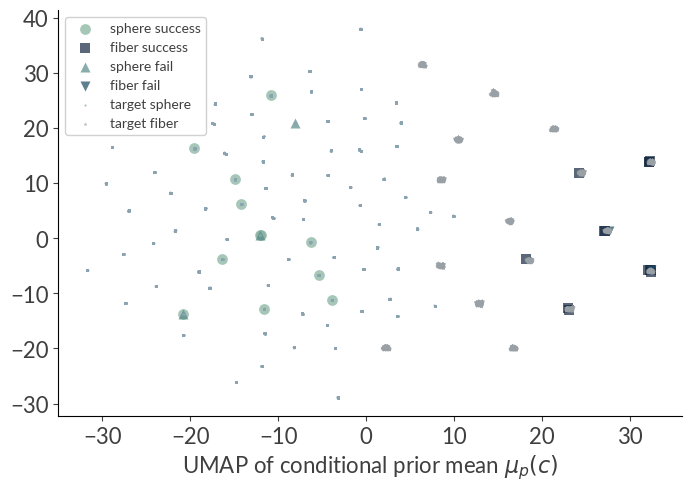

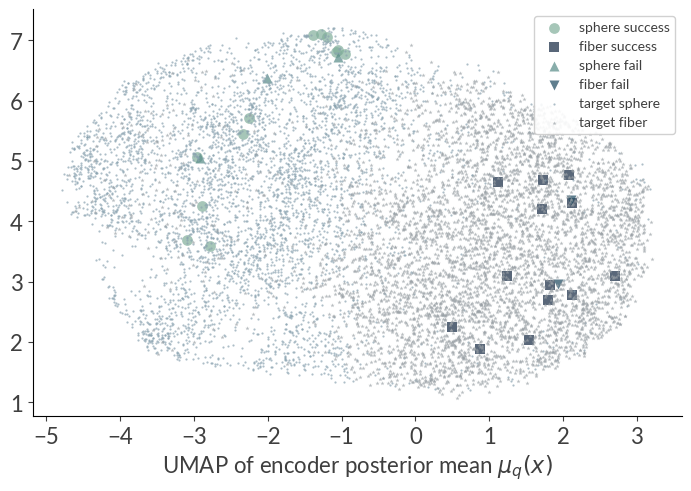

In [112]:
sim_df["_Zp_x"] = Zp[:,0]; sim_df["_Zp_y"] = Zp[:,1]
sim_df["_Zq_x"] = Zq[:,0]; sim_df["_Zq_y"] = Zq[:,1]

# ---------- 7) Plots ----------
# (A) Prior mu_p(c): where the conditional prior "wants" you to be
plot_scatter(sim_df, "_Zp_x", "_Zp_y",
             f"{meth_p} of conditional prior mean $\\mu_p(c)$",
             "simulated_prior_umap.svg")

# (B) Posterior mu_q(x): where sequences actually land in your CVAE latent
plot_scatter(sim_df, "_Zq_x", "_Zq_y",
             f"{meth_q} of encoder posterior mean $\\mu_q(x)$",
             "simulated_posterior_umap.svg")

/home/go46vuw/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


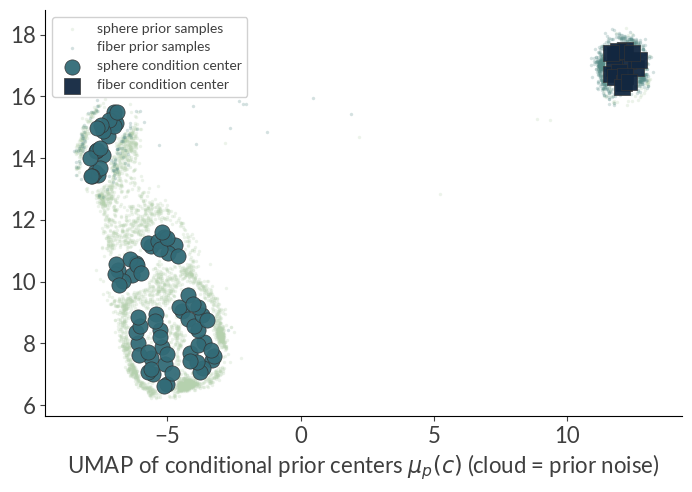

In [ ]:
def cond_signature(row):
    idxs = tuple(i for i,f in enumerate(FEATURES) if pd.notna(row[f]))
    vals = tuple(float(row[FEATURES[i]]) for i in idxs)
    return (row["target_morphology"], idxs, tuple(np.round(vals, 6)))

sim_df["cond_sig"] = sim_df.apply(cond_signature, axis=1)
uniq = sim_df.drop_duplicates("cond_sig").reset_index(drop=True)

m = cvae_model.module if hasattr(cvae_model,"module") else cvae_model
m.eval(); device = next(m.parameters()).device

def build_cond_mask_from_row_series(row):
    cond = np.zeros(len(FEATURES), dtype=np.float32)
    mask = np.zeros(len(FEATURES), dtype=np.float32)
    for i,feat in enumerate(FEATURES):
        if pd.notna(row[feat]):
            val = float(row[feat]); cond[i] = (val/MAX_FASTA_LENGTH) if feat=="length" else val
            mask[i] = 1.0
    return torch.tensor(cond), torch.tensor(mask)

mu_list, sigma_list, tgt_list = [], [], []
with torch.no_grad():
    C, M = [], []
    for _, r in uniq.iterrows():
        c, msk = build_cond_mask_from_row_series(r)
        C.append(c); M.append(msk); tgt_list.append(r["target_morphology"])
    C = torch.stack(C).to(device); M = torch.stack(M).to(device)
    summ = m.compute_summary(C, M)
    mup, logvp = m.compute_prior(summ)
    mu_list = mup.detach().cpu().numpy()
    sigma_list = np.exp(0.5 * logvp.detach().cpu().numpy())

centers = mu_list 
sigmas  = sigma_list
targets = np.array(tgt_list)

RS = np.random.default_rng(0)
SAMPLES_PER_COND = 40
z_points = []
z_colors = []
for u in range(len(centers)):
    mu = centers[u]
    sigma = sigmas[u]
    eps = RS.standard_normal((SAMPLES_PER_COND, mu.shape[0]))
    z = mu + eps * sigma
    z_points.append(z)
    z_colors.extend([targets[u]] * SAMPLES_PER_COND)
z_points = np.vstack(z_points)

reducer = umap.UMAP(n_neighbors=15, min_dist=0.15, metric="cosine", random_state=42)
centers_2d = reducer.fit_transform(centers)
noise_2d   = reducer.transform(z_points)

fig, ax = plt.subplots(figsize=(7.2, 5.2))

palette_cloud = {"sphere": TEAL[0], "fiber": TEAL[2]}
for tgt in ["sphere","fiber"]:
    mask = np.array(z_colors)==tgt
    if mask.sum():
        ax.scatter(noise_2d[mask,0], noise_2d[mask,1],
                   s=6, alpha=0.25, linewidths=0, color=palette_cloud[tgt], label=f"{tgt} prior samples")

for tgt, marker, col in [("sphere","o", TEAL[3]), ("fiber","s", TEAL[5])]:
    mask = (targets == tgt)
    if mask.sum():
        ax.scatter(centers_2d[mask,0], centers_2d[mask,1],
                   s=120, alpha=0.95, linewidth=0.5, edgecolor="#333333",
                   color=col, marker=marker, label=f"{tgt} condition center")

ax.set_xlabel("UMAP of conditional prior centers $\\mu_p(c)$ (cloud = prior noise)")
ax.set_ylabel("")
sns.despine(ax=ax)
ax.legend(frameon=True, fancybox=True, framealpha=0.9, fontsize=10, loc="best")
plt.tight_layout(); plt.show()
fig.savefig("cond_prior_centers_plus_noise.svg", format="svg", bbox_inches="tight", dpi=300)


In [ ]:
reducer = umap.UMAP(n_neighbors=15, min_dist=0.15, metric="cosine", random_state=42)
centers_2d = reducer.fit_transform(centers)
noise_2d   = reducer.transform(z_points)
post_2d    = reducer.transform(posterior_mu_np)

sig2idx = {sig: u for u, sig in enumerate(uniq["cond_sig"])}
seq_center_idx = sim_df["cond_sig"].map(sig2idx).to_numpy()


/home/go46vuw/miniconda3/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [ ]:
def plot_centers_by_target_color_by_length(sim_df,
                                           centers_2d,
                                           post_2d,
                                           center_targets,
                                           center_lengths,
                                           fname="cond_centers_lencol_posterior.svg"):
    """
    - Centers: shape encodes target (sphere='o', fiber='s'), color encodes length (5..10 mapped to TEAL palette).
    - Posterior μ_q(x): classes with your requested markers:
        sphere_success -> big 'o'
        fiber_success  -> big 's'
        sphere_fail    -> big '^'
        fiber_fail     -> big 'v'
        target_sphere  -> small '.'
        target_fiber   -> small '*'
    """
    
    # --- style ---
    TEAL = ["#e2eddf", "#b5d1ae", "#80ae9a", "#568b87", "#326b77", "#1b485e", "#122740"]
    length_colors = {4: TEAL[0], 5: TEAL[1], 6: TEAL[2], 7: TEAL[3], 8: TEAL[4], 9: TEAL[5], 10: TEAL[6]}
    # fallback for unexpected lengths
    def len2col(L): return length_colors.get(int(L), "#88919a")

    # posterior classes (μ_q(x))
    marker_map = {
        "sphere_success": "o",
        "fiber_success":  "s",
        "sphere_fail":    "^",
        "fiber_fail":     "v",
        "target_sphere":  ".",
        "target_fiber":   "*",
    }
    size_map = {
        "sphere_success": 90,
        "fiber_success":  90,
        "sphere_fail":    80,
        "fiber_fail":     80,
        "target_sphere":  10,
        "target_fiber":   28,
    }
    color_map = {
        "sphere_success": TEAL[6],
        "fiber_success":  TEAL[6],
        "sphere_fail":    TEAL[5],
        "fiber_fail":     TEAL[5],
        "target_sphere":  TEAL[2],
        "target_fiber":   TEAL[4],
    }

    # condition centers
    center_shapes = {"sphere": "o", "fiber": "s"}
    center_edge   = "#ffffff"
    center_ec_lw  = 0.6
    center_size   = 40
    center_alpha  = 0.95

    # --- plot ---
    fig, ax = plt.subplots(figsize=(7.2, 5.2))

    # 1) Posterior μ_q(x) — plot target-only first (faint), then success/fail (bold)
    order_targets  = ["target_sphere","target_fiber"]
    order_outcome  = ["sphere_success","fiber_success","sphere_fail","fiber_fail"]

    for lab in order_targets:
        m = (sim_df["success_label"] == lab).to_numpy()
        if m.any():
            ax.scatter(post_2d[m,0], post_2d[m,1],
                       s=size_map[lab], color=color_map[lab], marker=marker_map[lab],
                       alpha=0.50, linewidths=0, zorder=1, label=lab.replace("_"," "))

    for lab in order_outcome:
        m = (sim_df["success_label"] == lab).to_numpy()
        if m.any():
            ax.scatter(post_2d[m,0], post_2d[m,1],
                       s=size_map[lab], color=color_map[lab], marker=marker_map[lab],
                       alpha=0.95, linewidths=0, zorder=2, label=lab.replace("_"," "))

    # 2) Condition centers — shape by target, color by length
    center_targets = np.asarray(center_targets).astype(str)
    center_lengths = np.asarray(center_lengths).astype(int)
    for tgt, mk in center_shapes.items():
        mask = (center_targets == tgt)
        if mask.any():
            cols = [len2col(L) for L in center_lengths[mask]]
            ax.scatter(centers_2d[mask,0], centers_2d[mask,1],
                       s=center_size, c=cols, marker=mk,
                       alpha=center_alpha, linewidth=center_ec_lw, edgecolor=center_edge,
                       zorder=3, label=f"{tgt} condition center")

    #ax.set_xlabel("UMAP fit on $\\mu_p(c)$ centers — points: $\\mu_q(x)$; center shape: target; center color: length")
    #ax.set_ylabel("")
    sns.despine(ax=ax)

    # 3) Legends: (i) posterior classes; (ii) center shapes; (iii) length colors
    handles, labels = ax.get_legend_handles_labels()
    # Deduplicate while preserving order
    seen, H, L = set(), [], []
    for h, l in zip(handles, labels):
        if l not in seen:
            seen.add(l); H.append(h); L.append(l)

    # Build a length legend
    len_vals_present = sorted(set(int(L) for L in center_lengths if int(L) in range(5,11)))
    len_handles = [Line2D([0],[0], marker='o', color='none',
                          markerfacecolor=length_colors[k], markersize=8, label=f"L={k}") for k in len_vals_present]

    # Build a center-shape legend (neutral color; text states "color = length")
    center_shape_handles = [
        Line2D([0],[0], marker='o', color='none', markerfacecolor="#666", markeredgecolor=center_edge,
               markeredgewidth=center_ec_lw, markersize=9, label="sphere center"),
        Line2D([0],[0], marker='s', color='none', markerfacecolor="#666", markeredgecolor=center_edge,
               markeredgewidth=center_ec_lw, markersize=9, label="fiber center"),
    ]

    # Place legends
    leg1 = ax.legend(H, L, frameon=True, fancybox=True, framealpha=0.9, fontsize=10, loc="center right",
                     title="Posterior classes")
    ax.add_artist(leg1)
    leg2 = ax.legend(center_shape_handles, [h.get_label() for h in center_shape_handles],
                     frameon=True, fancybox=True, framealpha=0.9, fontsize=9, loc="lower right",
                     title="Condition center shape\n(color = length)")
    ax.add_artist(leg2)
    #leg3 = ax.legend(len_handles, [h.get_label() for h in len_handles],
    #                 frameon=True, fancybox=True, framealpha=0.9, fontsize=9, loc="upper right",
    #                 title="Center length")
    #ax.add_artist(leg3)

    plt.tight_layout(); plt.show()
    fig.savefig(fname, format="svg", bbox_inches="tight", dpi=300)


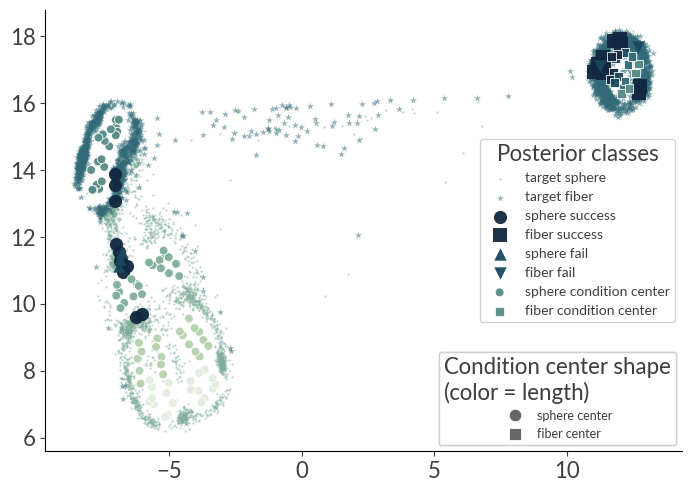

In [116]:
# centers computed from uniq (one row per unique condition)
# centers_2d = reducer.fit_transform(centers)
# post_2d    = reducer.transform(posterior_mu_np)

center_targets = uniq["target_morphology"].astype(str).tolist()
center_lengths = uniq["length"].astype(int).tolist()

plot_centers_by_target_color_by_length(sim_df,
                                       centers_2d,
                                       post_2d,
                                       center_targets=center_targets,
                                       center_lengths=center_lengths,
                                       fname="cond_centers_lencol_posterior.svg")


In [ ]:
def plot_centers_with_targets_len_cbar(sim_df,
                                       centers_2d,
                                       post_2d,
                                       center_targets,
                                       center_lengths,
                                       fname="centers_len_cbar.svg"):
    """
    - Target-only samples: sphere='.' with TEAL[3], fiber='*' with TEAL[5]
    - Condition centers: shape encodes target; color encodes length
    - Inset horizontal colorbar inside the plot with a solid border,
      gradient clipped strictly to the box (SVG-safe).
    """

    TEAL = ["#e2eddf", "#b5d1ae", "#80ae9a", "#568b87", "#326b77", "#1b485e", "#122740"]

    # Yellow gradient for conditions
    sun_colors = [
        "#ffe14d",  # vivid golden yellow (stronger start)
        "#ffc233",  # warm amber
        "#ff9f1c",  # orange-amber
        "#f07605",  # deep orange
        "#c95c00",  # burnt orange
        "#8a3f00",  # dark brownish orange
        "#4d2200"   # very dark brown
    ]

    sun_cmap = LinearSegmentedColormap.from_list("sun_grad", sun_colors)

    TARGET_COLORS = {"target_sphere": TEAL[3], "target_fiber": TEAL[5]}
    TARGET_MARKERS = {"target_sphere": ".", "target_fiber": "*"}
    TARGET_SIZES   = {"target_sphere": 12, "target_fiber": 30}
    TARGET_ALPHA   = 0.55

    center_shapes = {"sphere": "o", "fiber": "s"}
    center_edge   = "#ffffff"
    center_ec_lw  = 0.6
    center_size   = 42
    center_alpha  = 0.95

    center_targets = np.asarray(center_targets).astype(str)
    center_lengths = np.asarray(center_lengths).astype(float)
    vmin, vmax = float(np.nanmin(center_lengths)), float(np.nanmax(center_lengths))
    if vmin == vmax: vmin, vmax = vmin - 0.5, vmax + 0.5
    norm = Normalize(vmin=vmin, vmax=vmax)

    fig, ax = plt.subplots(figsize=(7.2, 5.2))

    # --- targets ---
    for lab in ("target_sphere", "target_fiber"):
        m = (sim_df["success_label"] == lab).to_numpy()
        if m.any():
            ax.scatter(post_2d[m,0], post_2d[m,1],
                       s=TARGET_SIZES[lab], c=TARGET_COLORS[lab],
                       marker=TARGET_MARKERS[lab], alpha=TARGET_ALPHA,
                       linewidths=0, zorder=1, label=lab.replace("_"," "))

    # --- centers ---
    for tgt, mk in center_shapes.items():
        mask = (center_targets == tgt)
        if mask.any():
            ax.scatter(centers_2d[mask,0], centers_2d[mask,1],
                       s=center_size, c=center_lengths[mask],
                       cmap=sun_cmap, norm=norm,
                       marker=mk, alpha=center_alpha,
                       linewidth=center_ec_lw, edgecolor=center_edge,
                       zorder=3)

    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)

    # --- inset colorbar ---
    sm = ScalarMappable(norm=norm, cmap=sun_cmap)
    sm.set_array([])

    cax = inset_axes(ax, width="35%", height="6%", loc="upper center",
                     borderpad=0.8)
    cbar = plt.colorbar(sm, cax=cax, orientation="horizontal")

    # force clipping of gradient to the axes box (fixes SVG bleed)
    if hasattr(cbar, "solids") and cbar.solids is not None:
        cbar.solids.set_edgecolor("face")
        cbar.solids.set_clip_on(True)

    # add border
    for spine in cbar.ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.8)
        spine.set_edgecolor("black")

    cbar.set_label("Condition length", labelpad=2, fontsize=9)
    cbar.ax.tick_params(labelsize=8)

    # --- legend ---
    text_color = plt.rcParams.get("text.color", "black")
    legend_handles = [
        Line2D([0],[0], marker='.', linestyle='None', markersize=8,
               markerfacecolor=TARGET_COLORS["target_sphere"], markeredgecolor=TARGET_COLORS["target_sphere"],
               label="target sphere"),
        Line2D([0],[0], marker='*', linestyle='None', markersize=10,
               markerfacecolor=TARGET_COLORS["target_fiber"], markeredgecolor=TARGET_COLORS["target_fiber"],
               label="target fiber"),
        Line2D([0],[0], marker='o', linestyle='None', markersize=9,
               markerfacecolor='none', markeredgecolor=text_color, label="sphere center"),
        Line2D([0],[0], marker='s', linestyle='None', markersize=9,
               markerfacecolor='none', markeredgecolor=text_color, label="fiber center"),
    ]
    ax.legend(legend_handles, [h.get_label() for h in legend_handles],
              frameon=True, fancybox=True, framealpha=0.9, fontsize=10,
              loc="lower right")

    plt.tight_layout()
    fig.savefig(fname, format="svg", bbox_inches="tight")
    plt.show()
    plt.close(fig)




# -------------------------------------------
# Plot B — outcomes only (success/fail), targets teal; outcomes use the SAME yellow gradient
# -------------------------------------------
def plot_posterior_outcomes_only(sim_df,
                                 post_2d,
                                 fname="posterior_outcomes_only.svg"):
    """
    - Target-only (context): sphere '.' = TEAL[3], fiber '*' = TEAL[5] (faint)
    - Outcomes: sphere_success 'o', fiber_success 's', sphere_fail '^', fiber_fail 'v'
      Colored with two DISTINCT colors sampled from the SAME yellow gradient used for centers in Plot A.
      (success = darker end, fail = mid/light end)
    """

    TEAL = ["#e2eddf", "#b5d1ae", "#80ae9a", "#568b87", "#326b77", "#1b485e", "#122740"]

    # yellow gradient (same as Plot A)
    sun_colors = [
        "#ffe14d",  # vivid golden yellow (stronger start)
        "#ffc233",  # warm amber
        "#ff9f1c",  # orange-amber
        "#f07605",  # deep orange
        "#c95c00",  # burnt orange
        "#8a3f00",  # dark brownish orange
        "#4d2200"   # very dark brown
    ]

    sun_cmap = LinearSegmentedColormap.from_list("sun_grad", sun_colors)

    # Targets (same as Plot A)
    target_color = {
        "target_sphere": TEAL[3],
        "target_fiber":  TEAL[5],
    }

    marker_map = {
        "sphere_success": "o",
        "fiber_success":  "s",
        "sphere_fail":    "^",
        "fiber_fail":     "v",
        "target_sphere":  ".",
        "target_fiber":   "*",
    }
    size_map = {
        "sphere_success": 90,
        "fiber_success":  90,
        "sphere_fail":    80,
        "fiber_fail":     80,
        "target_sphere":  10,
        "target_fiber":   28,
    }

    # Distinct outcome colors from the yellow gradient
    success_color = sun_cmap(0.82)  # darker, saturated amber
    fail_color    = sun_cmap(0.42)  # lighter/mid amber
    color_map = {
        "sphere_success": success_color,
        "fiber_success":  success_color,
        "sphere_fail":    fail_color,
        "fiber_fail":     fail_color,
        "target_sphere":  target_color["target_sphere"],
        "target_fiber":   target_color["target_fiber"],
    }

    fig, ax = plt.subplots(figsize=(7.2, 5.2))

    # Target-only (faint)
    for lab in ("target_sphere", "target_fiber"):
        m = (sim_df["success_label"] == lab).to_numpy()
        if m.any():
            ax.scatter(post_2d[m,0], post_2d[m,1],
                       s=size_map[lab], color=color_map[lab], marker=marker_map[lab],
                       alpha=0.50, linewidths=0, zorder=1, label=lab.replace("_"," "))

    # Outcomes (bold)
    for lab in ("sphere_success", "sphere_fail", "fiber_success", "fiber_fail"):
        m = (sim_df["success_label"] == lab).to_numpy()
        if m.any():
            ax.scatter(post_2d[m,0], post_2d[m,1],
                       s=size_map[lab], color=color_map[lab], marker=marker_map[lab],
                       alpha=0.95, linewidths=0, zorder=2, label=lab.replace("_"," "))

    # Ax cosmetics
    for spine in ("top", "right"):
        ax.spines[spine].set_visible(False)

    # De-duplicate legend, keep order
    handles, labels = ax.get_legend_handles_labels()
    seen, H, L = set(), [], []
    for h, l in zip(handles, labels):
        if l not in seen:
            seen.add(l); H.append(h); L.append(l)
    ax.legend(H, L, frameon=True, fancybox=True, framealpha=0.9, fontsize=10,
              loc="center right")

    plt.tight_layout()
    fig.savefig(fname, format="svg", bbox_inches="tight", dpi=300)
    plt.show()
    plt.close(fig)


/tmp/ipykernel_1036646/335286935.py:132: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


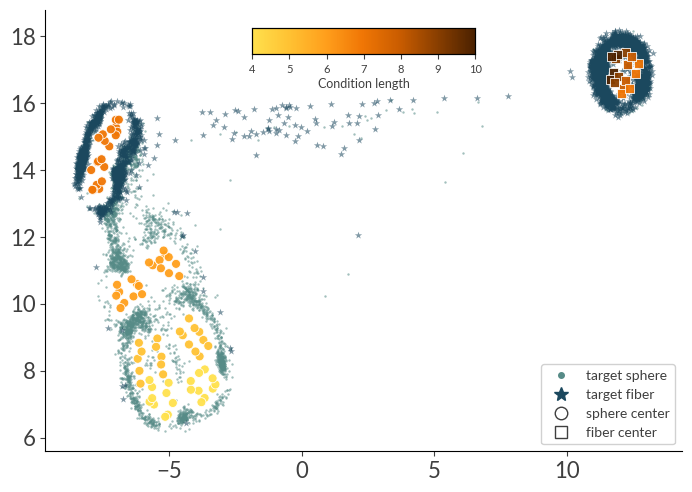

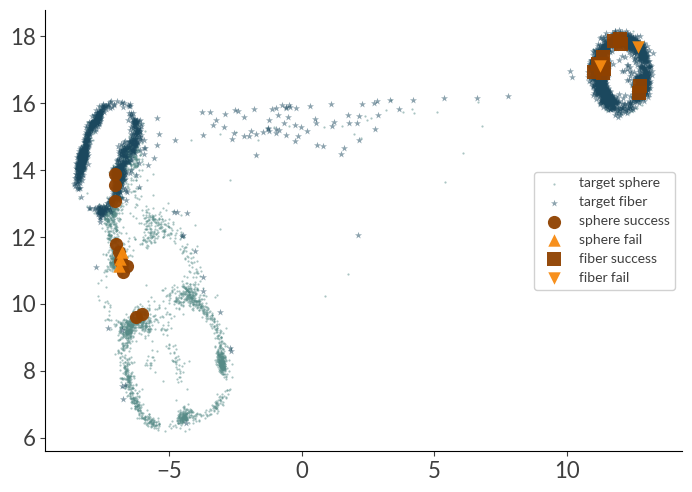

In [118]:
center_targets = uniq["target_morphology"].astype(str).tolist()
center_lengths = uniq["length"].astype(int).tolist()

# A: centers + targets (length via colorbar)
plot_centers_with_targets_len_cbar(
    sim_df, centers_2d, post_2d,
    center_targets=center_targets,
    center_lengths=center_lengths,
    fname="cond_centers_len_cbar.svg"
)

# B: outcomes only (success/fail emphasis)
plot_posterior_outcomes_only(
    sim_df, post_2d,
    fname="posterior_outcomes_only.svg"
)

